# Import section

In [65]:
%load_ext autoreload
%autoreload 2

import os
import random
from collections import Counter
from pprint import pprint
from textwrap import indent

import spacy
import nltk
from nltk.corpus import stopwords
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

from context import robot_judge  # Now we can use all the handy robot_judge functionality :-)
from robot_judge.nlp.language_models import spacy_nlp, stop_words
from robot_judge.utils import indent as indent_text

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# How-To

1) In the repo root directory there is a folder called _data_.  
2) Go there and create a folder called *assignment_1* (or whatever the DATA_DIR_NAME variable below is assigned to).   
3) Place all cases files (*1936_X9VD8L.txt*, ...) in there.  
4) Place the *case_reversed.csv* file in there.  
5) Run the code below.  

In [5]:
from robot_judge.io import ProblemSet1Io

In [6]:
N_SAMPLED_CASES = 1000
DATA_DIR_NAME = 'assignment_1'

In [7]:
io = ProblemSet1Io(data_dir=DATA_DIR_NAME)
sampled_cases = io.read_multiple_cases_files(n_samples=N_SAMPLED_CASES)

# Task 1
## Compute sentece, words and letters count per document and plot vs year

In [8]:
%%time  # Takse ~40min for 1000 cases

from robot_judge.exploration.corpus_analysis import count_words_sents_letters
from robot_judge.exploration.corpus_analysis import visualize_counts


labels, word_counts, sents_counts, letters_counts = count_words_sents_letters(sampled_cases)
years = [ProblemSet1Io.get_year_from_case_title(label) for label in labels]

CPU times: user 33min 1s, sys: 5min 43s, total: 38min 44s
Wall time: 23min 8s


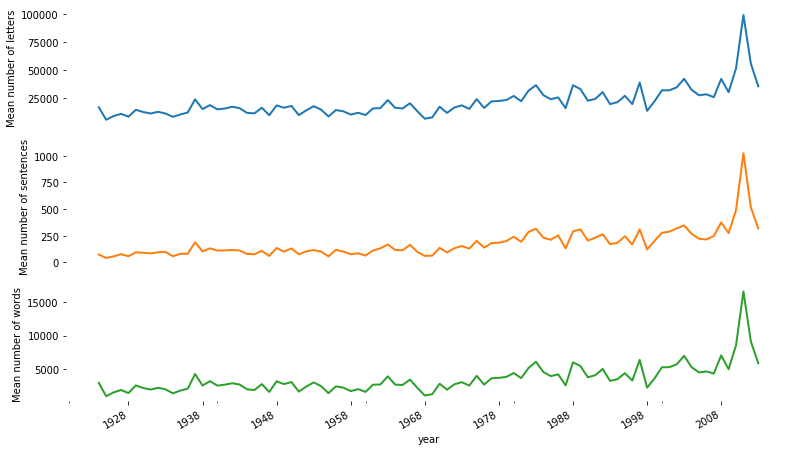

In [9]:
visualize_counts(years, word_counts, sents_counts, letters_counts)

# Task 2
## Plot part-of-speech (POS) tagging frequency vs year

In [10]:
from robot_judge.exploration.corpus_analysis import get_pos_tags
from robot_judge.exploration.corpus_analysis import aggregate_avg_pos_tags
from robot_judge.exploration.corpus_analysis import visualize_avg_pos_vs_year

In [11]:
%time years, pos_tags = get_pos_tags(sampled_cases, ProblemSet1Io.get_year_from_case_title)

CPU times: user 15min 6s, sys: 2min 41s, total: 17min 48s
Wall time: 10min


In [12]:
pos_df = aggregate_avg_pos_tags(years, pos_tags)

<Figure size 432x288 with 0 Axes>

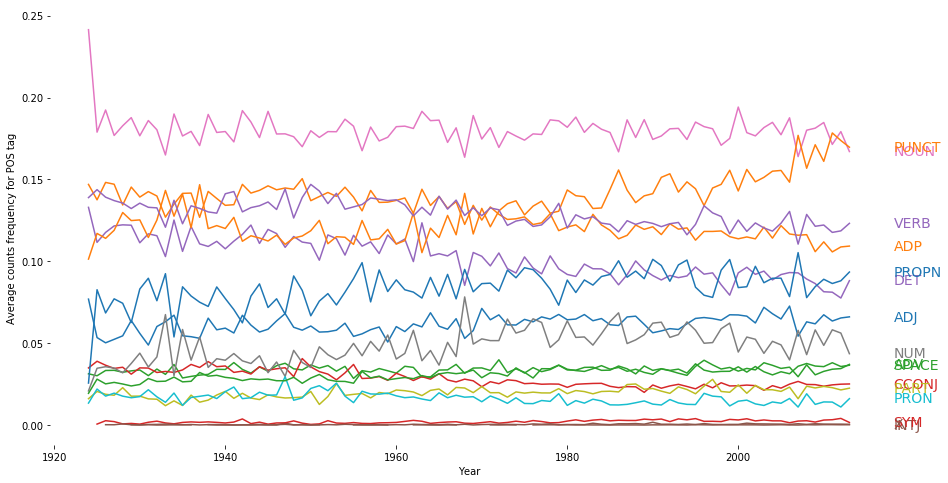

In [13]:
visualize_avg_pos_vs_year(pos_df)

# Task 3 
## Corpus normalization / cleaning & trigram creation

In [14]:
from robot_judge.nlp.ngrams import aggregate_clean_sentences, train_phrase_model, get_sents_from_sentence_dict
from gensim.models.phrases import Phrases, Phraser
from robot_judge.nlp.ngrams import print_label_sent_dict

In [15]:
test_corpus_dict = io.read_multiple_cases_files(N_SAMPLED_CASES)

In [16]:
unigram_sentences_dict = aggregate_clean_sentences(test_corpus_dict)

In [17]:
unigram_sentences = get_sents_from_sentence_dict(unigram_sentences_dict)

In [18]:
bigram_model = Phraser(train_phrase_model(unigram_sentences, min_count=2))

bigram_sentences = []
for sentence in unigram_sentences:
    bigram_sentences.append(bigram_model[sentence])
    
bigram_sentence_dict = {}
for label, sentences in unigram_sentences_dict.items():
    bigram_sentence_dict[label] = list(bigram_model[sentences])

In [19]:
trigram_model = Phraser(train_phrase_model(bigram_sentences, min_count=1))

trigram_sentences = []
for sentence in bigram_sentences:
    trigram_sentences.append(trigram_model[sentence])
    
trigram_sentence_dict = {}
for label, sentences in bigram_sentence_dict.items():
    trigram_sentence_dict[label] = list(trigram_model[sentences])

In [20]:
# print_label_sent_dict(trigram_sentence_dict)

# Task 4
## Create data frame of features

In [21]:
import itertools
from robot_judge.nlp.ngrams import create_df_from_label_sent_dict
from robot_judge.nlp.ngrams import get_labels_without_year
from robot_judge.nlp.ngrams import get_target_values

feat_df = create_df_from_label_sent_dict(trigram_sentence_dict)
target_labels = get_labels_without_year(feat_df)
target_values = get_target_values(target_labels)

In [22]:
feat_df.insert(0, 'case_reversed__', target_values)
feat_df.fillna(0.0, inplace=True)

y = feat_df['case_reversed__']
X = feat_df.loc[:, feat_df.columns != 'case_reversed__']

# Task 5
## Create training / test set

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
pipeline = Pipeline([('std_scaler', StandardScaler()),
                     ('log_regr', LogisticRegression())])

param_grid = {'log_regr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, refit=True)
clf = clf.fit(X_train, y_train)

In [26]:
y_pred = clf.predict(X_test)

In [27]:
print('Classification report:\n')
print(classification_report(y_test, y_pred))

Classification report:

             precision    recall  f1-score   support

          0       0.33      0.30      0.32        69
          1       0.65      0.67      0.66       131

avg / total       0.54      0.55      0.54       200



# Task 6
## GridsearchCV and ROC / AUC evaluation

In [28]:
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_roc
from robot_judge.ml import transform_to_text_label

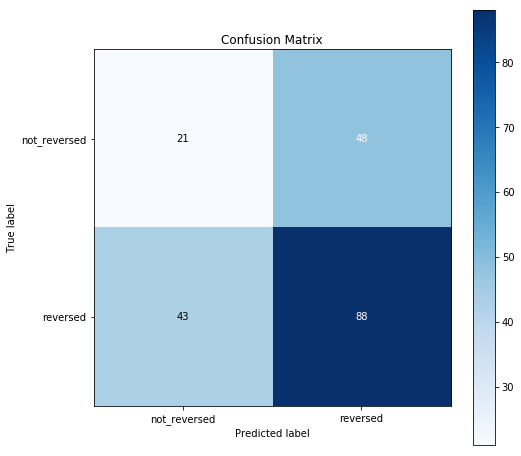

In [29]:
y_true_labels = transform_to_text_label(y_test, 'not_reversed', 'reversed')
y_pred_labels = transform_to_text_label(y_pred, 'not_reversed', 'reversed')

_ = plot_confusion_matrix(y_true_labels, y_pred_labels, figsize=(8, 8))

For AUC score, see plot.


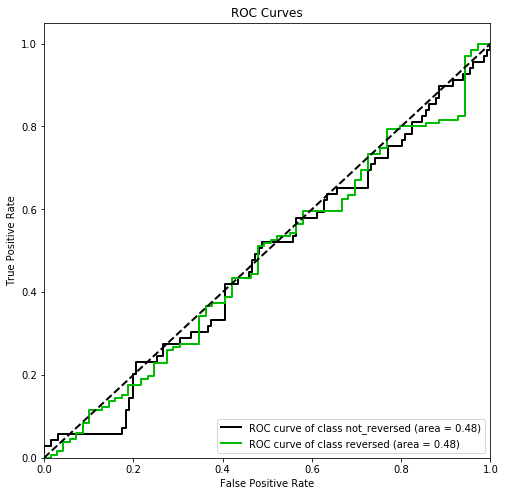

In [30]:
y_proba = clf.predict_proba(X_test)
_ = plot_roc(y_true_labels, y_proba, title='ROC Curves', figsize=(8, 8), plot_macro=False, plot_micro=False)
print('For AUC score, see plot.')

# Task 7 
## Vader compound sentiment scores

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/matthausheer/.pyenv/versions/skills_ml_env/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
%%time 

def label_case_dict_to_sentence_list(label_case_dict):
    all_sentences = []
    for case_text in sampled_cases.values():
        for sentence in spacy_nlp(case_text).sents:
            all_sentences.append(sentence.text)
    return all_sentences

all_sentences = label_case_dict_to_sentence_list(sampled_cases)

CPU times: user 16min 17s, sys: 3min 40s, total: 19min 57s
Wall time: 12min 50s


In [35]:
sid = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(sentences):
    sentence_scores = []
    for sentence in sentences:
        pol_score = sid.polarity_scores(sentence)
        
        score_dict = {key: value for key, value in pol_score.items()}
        score_dict['text'] = sentence
        
        sentence_scores.append(score_dict)
    return sentence_scores

sentence_scores = calculate_sentiment_scores(all_sentences[:1000])

sent_df = pd.DataFrame(sentence_scores).sort_values(by='pos', ascending=False)
print('Most POSITIVE sentences:')
for idx, sent in enumerate(sent_df['text'][:10]):
    print('\t', idx, sent)

sent_df = pd.DataFrame(sentence_scores).sort_values(by='neg', ascending=False)  
print('Most NEGATIVE sentences:')
for idx, sent in enumerate(sent_df['text'][:10]):
    print('\t', idx, sent)

Most POSITIVE sentences:
	 0 Birmingham Trust Nat.
 
	 1 Birmingham Trust Nat.
 
	 2 Although a union has a powerful interest in maintaining its strength during a strike, see N.L.R.B.
 
	 3 1692, 1697-98 , 143 L.Ed.2d 818 (1999).
 
	 4 The Supreme Court decided that the employees' interests took precedence.
 
	 5 See United States v. Woodrum ,
	 6 The strike ended December 19, 1977, when the parties agreed on a new collective bargaining agreement.
 
	 7 Id. ; Birmingham Trust , 755 F.2d at 1477 .
 
	 8 Suspicion had focused on Knights, and on his friend, Steven Simoneau.
 
	 9 The President found that Hamdan was not a prisoner of war under the Convention.
 
Most NEGATIVE sentences:
	 0 86.
 
	 1 No. 4,
	 2 That is by no stretch a jurisdictional argument.
 
	 3 Consequently, those courts have held that punitive damages for fraud are dischargeable, notwithstanding 523(a)(2)(A).
 
	 4 This was an error.
 
	 5 First, in the absence of the fraud that gave rise to the nondischargeable, compe

# Task 8
## tf-idf vectorizer and sentence similarity

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from robot_judge.utils.data_structs import sort_coo_matrix

In [38]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(all_sentences[:100])
X_tfidf_sparse = sparse.csr_matrix(X_tfidf)

In [39]:
# Calculates the ten highest cosine similarities
cos_sim = sparse.coo_matrix(sparse.tril(cosine_similarity(X_tfidf_sparse, dense_output=False)))
cos_sim = [sim for sim in sort_coo_matrix(cos_sim)]
cos_sim = [sim for sim in cos_sim if sim[0] != sim[1]]
cos_sim = [sim for sim in cos_sim if sim[2] < 1.0]

In [40]:
# Printing best cos similarities score
cos_sim

[(94, 91, 0.5994347465176406),
 (35, 15, 0.5279788602814299),
 (35, 4, 0.4367682202739865),
 (4, 3, 0.4348483177614455),
 (15, 4, 0.41365785977076175),
 (91, 76, 0.40209384749700894),
 (35, 20, 0.3972978002451799),
 (40, 4, 0.37253168822433425),
 (35, 34, 0.37057408836494904),
 (40, 35, 0.3610847602765346),
 (48, 42, 0.35856651132310785),
 (42, 36, 0.3558962655758335),
 (15, 5, 0.3555697122256072),
 (35, 14, 0.3548797719615659),
 (25, 20, 0.3521091597263961),
 (67, 64, 0.3476860809646342),
 (35, 16, 0.3451249669938449),
 (35, 7, 0.34107821040308933),
 (40, 16, 0.33600407862841064),
 (89, 52, 0.33557833366235357),
 (96, 81, 0.3276844874165869),
 (61, 59, 0.32709439556433567),
 (35, 32, 0.31721660060364976),
 (55, 6, 0.31615956417900803),
 (50, 0, 0.31562000363335985),
 (40, 15, 0.3135099691712885),
 (86, 51, 0.3118459069566749),
 (87, 78, 0.31125259107533837),
 (33, 32, 0.3067777737938342),
 (44, 21, 0.30583030987744286),
 (35, 3, 0.3034861268280081),
 (3, 1, 0.30181231070228987),
 (44,

In [41]:
# Print sentence with high cos similarity

for idx_1, idx_2, score in cos_sim:  
    print('Cos sim score: {}\n'.format(score))
    print(all_sentences[idx_1])
    print(all_sentences[idx_2])
    print(20 * '-')

Cos sim score: 0.5994347465176406

Id. at 429 , 89 S.Ct.
Scofield , 394 U.S. at 429-30 , 89 S.Ct.
--------------------
Cos sim score: 0.5279788602814299

It follows, therefore, that the attempted cancellation of the minor was ineffective; that it was never ratified by himself after majority or by the beneficiary; that the government is charged with notice of his minority, the condition upon which his enlistment was accepted and the specified interest of his mother as beneficiary, expressly reserved in the consent to enlistment, and could not rightfully act upon the cancellation without notice to the beneficiary, but was bound, in the absence of such notice, to collect the premiums and maintain the policy by deductions from the insured's salary, as previously; and that, therefore, the insurance being in full force and effect at the time of the deceased's death, the beneficiary is entitled to recover.
 
The government was charged with notice of his age and, by the terms of the instrument

--------------------
Cos sim score: 0.14525585409396857

In the same letter he invited further correspondence relative to the claim.
 
Reliance upon the cancellation is in the nature of an assertion of estoppel against the beneficiary because of the action of the minor during his minority, but this is "but a claim that he has assented or contracted.
 
--------------------
Cos sim score: 0.14509519303451548

Having an insurable interest and a property right in the resulting contract, such a party is protected against cancellation attempted by the insured, without notice to him.
 
Appellant contends that, because of the minor's attempted cancellation of the policy some months prior to his death, there is no liability.
 
--------------------
Cos sim score: 0.14508707456808026

This apparent conflict is reflected in Section 7 of the NLRA, 29 U.S.C. 157 (1947), which guarantees employees "the right to self-organization, to engage in other concerted activities for the purpose of collective b

 
Assertion of estoppel by cancellation must in the very nature of things be the assertion of legal competency to perform legal acts such as the making of contracts; such acts may not be asserted against the minor to his prejudice.
 
--------------------
Cos sim score: 0.10771944270961939

It is said by appellant, however, that there is no evidence of wages due the insured from which the premiums could be deducted.
 
Consequently, the son and the government could not, by arrangement wholly between themselves, without notice to her, set at naught the specified condition.
 
--------------------
Cos sim score: 0.10761159662015846

Having an insurable interest and a property right in the resulting contract, such a party is protected against cancellation attempted by the insured, without notice to him.
 
This consent, the court found, was executed by both parents in order to comply with the statute which provides that minors between the age of 14 and 18 shall not be enlisted for naval servi

Second, unions must be allowed flexibility to regulate their internal affairs without the interference of Congress or the courts.
 
There was substantial evidence to sustain the finding of the District Court that at the time of his entry into the Navy there was written across the consent of the young man's parents to his enlistment a clause providing that such consent was given upon condition that he obtain and carry a $10,000 contract for war risk insurance in which his mother should be named as beneficiary.
 
--------------------
Cos sim score: 0.08445230299742251

Presumably he was referring to the insurance claim.
 
This consent, the court found, was executed by both parents in order to comply with the statute which provides that minors between the age of 14 and 18 shall not be enlisted for naval service without the consent of the parents or guardian.
 
--------------------
Cos sim score: 0.08442240894492051

The National Labor Relations Board ruled that the Union violated Section 

--------------------
Cos sim score: 0.06047608363467082

The insured remained in the service at all times during his lifetime after his enlistment.
 
Early in the year of 1921 he sailed as a member of the crew of the U. S. S. Conastoga from San Francisco, Cal.
--------------------
Cos sim score: 0.06037283413977293

First, employees should not be restrained from exercising their right to refrain from collective bargaining activities.
 
The issue of resignations from unions presents an apparent conflict between two fundamental policies underlying the NLRA.
 
--------------------
Cos sim score: 0.060325465201791405

(A) of the National Labor Relations Act, 29 U.S.C. 158(b)(1)(A) (1974), by fining individuals who had tendered resignations from the Union and returned to work in violation of League Law 13.
 
Benson Charles Williams, aged seventeen years, enlisted in the naval service January 13, 1919.
 
--------------------
Cos sim score: 0.060203645903815786

The Board rested its decision 

Cos sim score: 0.04364676982027334

The issue of resignations from unions presents an apparent conflict between two fundamental policies underlying the NLRA.
 
As a result, the insured was declared deceased, by the Navy Department, as of June 30, 1921.
 
--------------------
Cos sim score: 0.043596345178873695

In Dalmo Victor , the Board determined that a union's constitutional provision prohibiting members from resigning during a strike or within fourteen days preceding its commencement was invalid and thus unenforceable.
 
So, here, the mother gave the required consent to the services of her son in behalf of the government upon the express condition that the insurance, payable to her, be maintained.
 
--------------------
Cos sim score: 0.04356955019914718

The Scofield Court stated that "it has become clear that if the rule invades or frustrates an overriding policy of the labor laws the rule may not be enforced, even by fine or expulsion, without violating 8(b)(1) ."
 
First, empl

--------------------
Cos sim score: 0.021354782719267155

True it is, that previously, in 1921, the director indicated that he was relying upon the cancellation, but we do not believe that his letter to this effect can be treated as final denial of the claim, for he said, "I shall be pleased to give further consideration to this claim."
 
Benson Charles Williams, aged seventeen years, enlisted in the naval service January 13, 1919.
 
--------------------
Cos sim score: 0.021348752068555663

The strike ended December 19, 1977, when the parties agreed on a new collective bargaining agreement.
 
It is at least a rebuttable presumption that his pay continued upon the same terms as previously and, in the absence of evidence rebutting such presumption, it must control.
 
--------------------
Cos sim score: 0.021252015649767034

Although the Supreme Court has not resolved this issue, its decisions guide our analysis of the Union's claim.
 
The first employee resigned on September 11.
 
------

# Task 9
## K-meayns clustering of sentences

In [49]:
import collections
from sklearn.cluster import KMeans

In [70]:
def cluster_texts(tfidf_model, texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering


clusters = cluster_texts(X_tfidf, all_sentences[:100], 7)

def print_sampled_texts_from_clusters(clusters, sentences, n_sample_per_cluster):
    for cluster_id, text_indices in clusters.items():
        
        print('Cluster number {}:'.format(cluster_id))
        
        sample_indices = random.sample(text_indices, n_sample_per_cluster)
        
        for idx in sample_indices:
            print('\t', sentences[idx])
    
print_sampled_texts_from_clusters(clusters, all_sentences[:100], 3)

Cluster number 0:
	 422 (1972).
 
	 Under the law quite generally, a minor is without capacity to contract or take other legal action except for necessaries.
 
	 Mutual Life Insurance v. Schiavone , 63 App.
Cluster number 5:
	 The issue of resignations from unions presents an apparent conflict between two fundamental policies underlying the NLRA.
 
	 Because League Law 13 imposed the same type of restriction as the provision struck down in Dalmo Victor as an unreasonable restriction on a union member's Section 7 right to resign, the Board held that fines imposed pursuant to the law violated Section 8(b)(1)
	 So, here, the mother gave the required consent to the services of her son in behalf of the government upon the express condition that the insurance, payable to her, be maintained.
 
Cluster number 2:
	 On May 5, 1977, the Union struck members of Intervenor Rockford-Beloit Pattern Jobbers Association (the Employer), a multi-employer bargaining unit consisting of eleven companies eng

# Testing

In [ ]:
test_doc = spacy_doc(read_file('1934_X3ITKT.txt'))

In [ ]:
test_doc = remove_punct_and_sym(test_doc)
test_doc = remove_ws_tokens(test_doc)
test_doc = lemmatize(test_doc)
no_stop = remove_stopwords(test_doc)

In [ ]:
pos_tags_1 = []
for token in test_doc:
    pos_tags_1.append(token.pos_)

In [ ]:
Counter(pos_tags_1)

In [ ]:
Counter(pos_tags) + Counter(pos_tags_1)